# PyTorch Computer Vision

## 목차
1. 실행 환경 세팅
2. FashionMNIST dataset 다운로드
3. 다운로드 받은 image visualize하는 함수 만들기 + 테스트
4. FashionMNIST를 DataLoader화 하기
    - Batch화라던지 data를 shuffle한다든지 하는걸 더 편리하게 할 수 있음
    - DataLoader에 대한 것은 다음 section인 Custom DataSets에서 좀 더 자세히 다룬다
5. Training loop / Test loop function 만들기
6. Linear Model 만들어서 테스트 해 보기
    - Linear model은 flatten을 통해 1차원으로 만들어야 한다
    - 생각보다는 결과가 잘 나온다
7. Non-linear model로 만들어서 테스트 해보기
    - Linear model보다는 결과가 좋다
    - 하지만 epoch 4-5 정도부터는 overfitting이 발생한다
8. CNN model
    - TinyVGG 에서 모델 architecture를 복제함 (https://poloclub.github.io/cnn-explainer/)
    - 상당히 괜찮게 결과가 나온다 (단 learning rate는 줄이고 epoch은 늘려야 한다)

In [57]:
# 1. 실행 환경 세팅

import matplotlib.pyplot

import mlxtend  # confusion matrix 용
import mlxtend.plotting

import random

import time
import timeit   # 시간 재기 용

import torch
import torch.nn
import torch.utils.data

import torchmetrics
import torchmetrics.functional

import torchvision
import torchvision.datasets
import torchvision.transforms

import tqdm.auto  # progress bar 용

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [58]:
# 2. FashionMNIST dataset 다운로드

# training data
train_data = torchvision.datasets.FashionMNIST(
    root="data_FashionMNIST",                    # 다운로드 할 폴더 이름
    train=True,                                  # train/test data 여부. True면 train data를 다운로드
    download=True,                               # 디스크에 없으면 다운로드 한다
    transform=torchvision.transforms.ToTensor(), # 다운로드시 PIL format으로 오므로 Torch tensor로 변환해 준다
    target_transform=None                        # Label transform도 가능함. 여기서는 하지 않는다
)

# test data
test_data = torchvision.datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=False,                                 # train/test data 여부. False면 test data를 다운로드
    download=True,
    transform=torchvision.transforms.ToTensor()
)

class_names = train_data.classes

# 10개의 class가 있다
print(f'class_names : {class_names} (count: {len(class_names)})')

# train data는 60,000개, test data는 10,000개가 있다
print(f'len(train_data.data):    {len(train_data.data)}')
print(f'len(train_data.targets): {len(train_data.targets)}')
print(f'len(test_data.data):     {len(test_data.data)}')
print(f'len(test_data.targets):  {len(test_data.targets)}')

class_names : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] (count: 10)
len(train_data.data):    60000
len(train_data.targets): 60000
len(test_data.data):     10000
len(test_data.targets):  10000


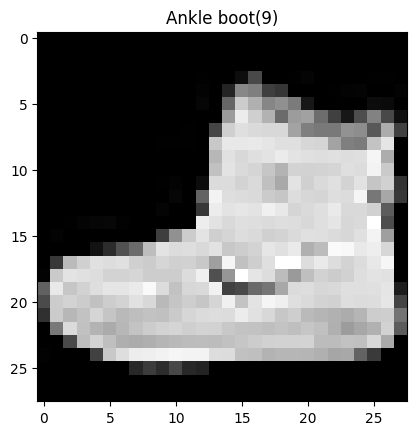

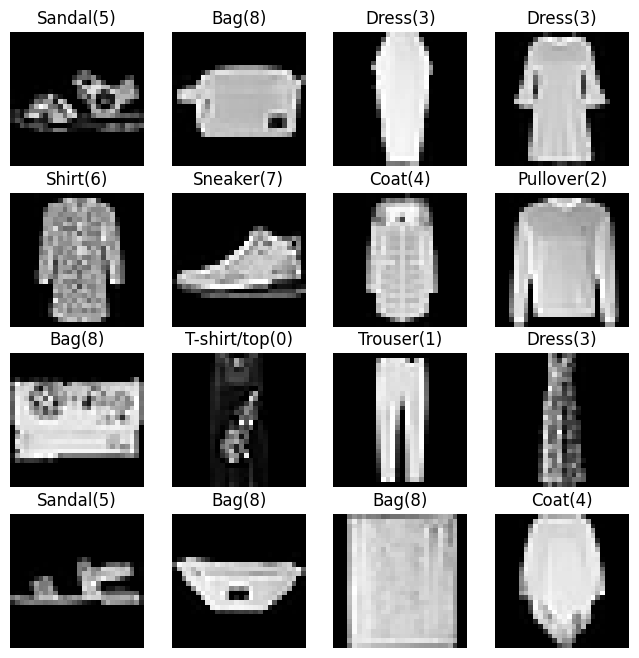

In [59]:
# 3. 다운로드 받은 image visualize하는 함수 만들기 + 테스트

def display_grayscale_image(image, title=None):
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.imshow(image, cmap='gray')
    matplotlib.pyplot.show()

def display_image_table(rows, cols, title_image_pair_list):
    fig = matplotlib.pyplot.figure(figsize=(cols*2, rows*2))
    for i in range(rows * cols):
        fig.add_subplot(rows, cols, i + 1)
        title, image = title_image_pair_list[i]
        matplotlib.pyplot.title(title)
        matplotlib.pyplot.imshow(image, cmap='gray')
        matplotlib.pyplot.axis(False) # axis는 보이지 않게 한다
    matplotlib.pyplot.show()

# train data의 첫번째 이미지를 확인해 본다
image, label = train_data[0]
image = image.squeeze() # squeeze()를 해 주어야 imshow가 정상적으로 작동한다
display_grayscale_image(image, f'{class_names[label]}({label})')

# train data에서 10개를 random하게 선택해 확인해 본다
rows, cols = 4,4
random_idx_list = random.sample(range(len(train_data)), rows*cols)
title_image_pair_list = []
for ri in random_idx_list:
    image, label = train_data[ri]
    # image.squeeze()를 해 주어야 imshow가 정상적으로 작동한다
    title_image_pair_list.append((f'{class_names[label]}({label})', image.squeeze()))

display_image_table(rows, cols, title_image_pair_list)


In [60]:
# 4. FashionMNIST를 DataLoader화 하기
#     - Batch화라던지 data를 shuffle한다든지 하는걸 더 편리하게 할 수 있음
#     - DataLoader에 대한 것은 다음 section인 Custom DataSets에서 좀 더 자세히 다룬다

BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(
    train_data,             # dataset to turn into iterable
    batch_size=BATCH_SIZE,  # how many samples per batch? 
    shuffle=True            # 매 epoch마다 data를 shuffle한다
)

test_dataloader = torch.utils.data.DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # test data는 shuffle할 필요가 없다
)

# dataloader의 shape 확인
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print()

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print()

# 각 batch의 생김새
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f'train_features_batch.shape = {train_features_batch.shape}') # torch.Size([32, 1, 28, 28])
print(f'train_labels_batch.shape = {train_labels_batch.shape}') # torch.Size([32])

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ff55f7556d0>, <torch.utils.data.dataloader.DataLoader object at 0x7ff5fd2e5450>)

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32

train_features_batch.shape = torch.Size([32, 1, 28, 28])
train_labels_batch.shape = torch.Size([32])


In [67]:
# 5. Training loop / Test loop / Confusion matrix function 만들기
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    
    train_loss = 0.0
    train_precision = 0.0
    train_recall = 0.0

    model.to(device)

    for bi, (X,y) in enumerate(data_loader): # batch 단위로 주어진다
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # # 2. Calculate loss
        loss = loss_fn(y_pred, y) # loss는 하나의 scalar로 나온다
        train_loss += loss

        train_precision += torchmetrics.functional.precision(y_pred, y, task='multiclass', num_classes=10, average='micro')
        train_recall += torchmetrics.functional.recall(y_pred, y, task='multiclass',num_classes=10, average='micro')
    
        # 3. Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 4. Calculate average loss
    train_loss /= len(data_loader)
    train_precision /= len(data_loader)
    train_recall /= len(data_loader)

    print(f'train_loss: {train_loss}    train_precision: {train_precision}    train_recall: {train_recall}')


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    
    test_loss = 0.0
    test_precision = 0.0
    test_recall = 0.0

    model.to(device)
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_precision += torchmetrics.functional.precision(test_pred, y, task='multiclass', num_classes=10, average='micro')
            test_recall += torchmetrics.functional.recall(test_pred, y, task='multiclass', num_classes=10, average='micro')
        
        test_loss /= len(data_loader)
        test_precision /= len(data_loader)
        test_recall /= len(data_loader)

    print(f'test_loss: {test_loss}    test_precision: {test_precision}    test_recall: {test_recall}')

def display_confusion_matrix(
        data_loader: torch.utils.data.DataLoader,
        model: torch.nn.Module,
        class_names: list[str],
        device: torch.device = device
    ):
    model.to(device)
    y_pred_list  = []
    y_label_list = []
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device), y.to(device)
            y_logit = model(X)
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            y_pred_list.append(y_pred.cpu())
            y_label_list.append(y.cpu())
    
    y_pred_tensor = torch.cat(y_pred_list)
    y_label_tensor = torch.cat(y_label_list)

    confusion_matrix = torchmetrics.ConfusionMatrix(num_classes = len(class_names), task='multiclass')
    confusion_matrix_tensor = confusion_matrix(preds=y_pred_tensor, target=y_label_tensor)

    fig, ax = mlxtend.plotting.plot_confusion_matrix(
        conf_mat=confusion_matrix_tensor.numpy(),
        class_names = class_names,
        figsize=(10,7)
    )
    matplotlib.pyplot.show()

Epoch: 1/10
train_loss: 0.5581681728363037    train_precision: 0.8038666844367981    train_recall: 0.8038666844367981
test_loss: 0.5468026995658875    test_precision: 0.8102036714553833    test_recall: 0.8102036714553833
Epoch: 2/10
train_loss: 0.46359556913375854    train_precision: 0.838783323764801    train_recall: 0.838783323764801
test_loss: 0.4982617497444153    test_precision: 0.8279752135276794    test_recall: 0.8279752135276794
Epoch: 3/10
train_loss: 0.4481063485145569    train_precision: 0.8443666696548462    train_recall: 0.8443666696548462
test_loss: 0.5580651164054871    test_precision: 0.797723650932312    test_recall: 0.797723650932312
Epoch: 4/10
train_loss: 0.44177520275115967    train_precision: 0.8462833166122437    train_recall: 0.8462833166122437
test_loss: 0.4640825092792511    test_precision: 0.8382587432861328    test_recall: 0.8382587432861328
Epoch: 5/10
train_loss: 0.4330862760543823    train_precision: 0.8493666648864746    train_recall: 0.8493666648864746


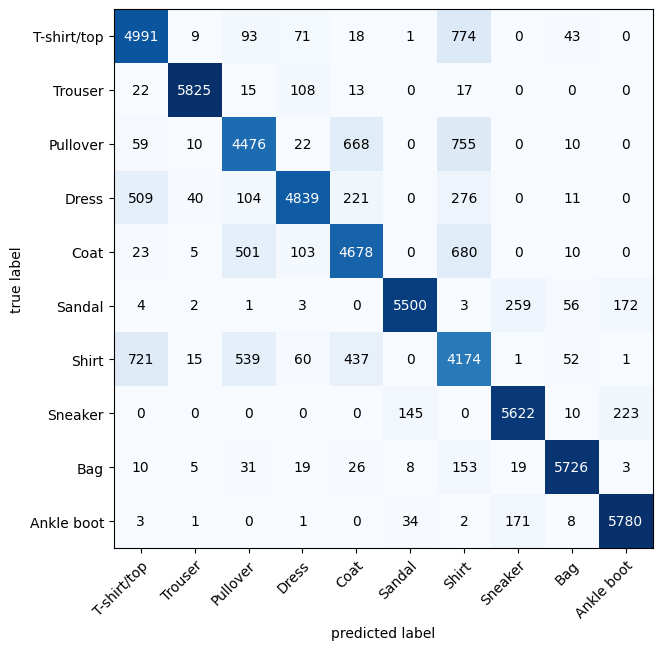

In [69]:
# 6. Linear Model 만들어서 테스트 해 보기
#    - Linear model은 flatten을 통해 1차원으로 만들어야 한다
#    - 생각보다는 결과가 잘 나온다

class FashionMNISTLinearClassifier(torch.nn.Module):
    def __init__(self, input_shape, output_shape, hidden_unit_list):
        super().__init__()
        
        layer_list = []
        layer_list.append(torch.nn.Flatten())
        layer_list.append(torch.nn.Linear(input_shape, hidden_unit_list[0]))
        for i in range(len(hidden_unit_list) - 1):
            layer_list.append(torch.nn.Linear(hidden_unit_list[i], hidden_unit_list[i+1]))
        layer_list.append(torch.nn.Linear(hidden_unit_list[-1], output_shape))

        self.layers = torch.nn.Sequential(*layer_list)
    
    def forward(self, X):
        return self.layers(X)
    
# train data의 첫번째 이미지에서 크기를 가져온다    
image, label = train_data[0]
image_size = image.shape[1] * image.shape[2]
    
model_linear = FashionMNISTLinearClassifier(
    input_shape  = image_size,
    output_shape = len(class_names),
    hidden_unit_list = [128, 64, 32]
).to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_linear.parameters(), lr=0.001)
epochs = 10

t_start = timeit.default_timer()

for e in range(epochs):
    print(f'Epoch: {e+1}/{epochs}')
    train_step(model_linear, train_dataloader, loss_func, optimizer)
    test_step(test_dataloader, model_linear, loss_func)

t_end = timeit.default_timer()

print(f'Elapsed time: {t_end - t_start:.2f} seconds')

display_confusion_matrix(train_dataloader, model_linear, class_names)


Epoch: 1/10
train_loss: 0.5544572472572327    train_precision: 0.799916684627533    train_recall: 0.799916684627533
test_loss: 0.4518236517906189    test_precision: 0.8380590677261353    test_recall: 0.8380590677261353
Epoch: 2/10
train_loss: 0.3875129520893097    train_precision: 0.8579666614532471    train_recall: 0.8579666614532471
test_loss: 0.3935893774032593    test_precision: 0.8579273223876953    test_recall: 0.8579273223876953
Epoch: 3/10
train_loss: 0.34561604261398315    train_precision: 0.8730666637420654    train_recall: 0.8730666637420654
test_loss: 0.3682939410209656    test_precision: 0.8673123121261597    test_recall: 0.8673123121261597
Epoch: 4/10
train_loss: 0.3207085132598877    train_precision: 0.883233368396759    train_recall: 0.883233368396759
test_loss: 0.3776159882545471    test_precision: 0.8646165728569031    test_recall: 0.8646165728569031
Epoch: 5/10
train_loss: 0.3055728077888489    train_precision: 0.8860833644866943    train_recall: 0.8860833644866943
t

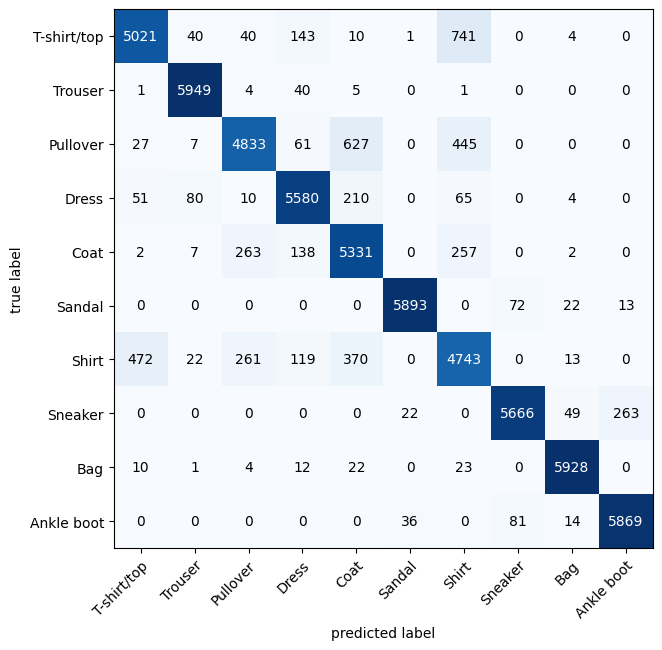

In [70]:
# 7. Non-linear model도 테스트 해 보기
#    - Linear model보다 결과가 좋다

class FashionMNISTMLPClassifier(torch.nn.Module):
    def __init__(self, input_shape, output_shape, hidden_unit_list):
        super().__init__()
        
        layer_list = []
        layer_list.append(torch.nn.Flatten())
        layer_list.append(torch.nn.Linear(input_shape, hidden_unit_list[0]))
        layer_list.append(torch.nn.ReLU())
        for i in range(len(hidden_unit_list) - 1):
            layer_list.append(torch.nn.Linear(hidden_unit_list[i], hidden_unit_list[i+1]))
            layer_list.append(torch.nn.ReLU())
        layer_list.append(torch.nn.Linear(hidden_unit_list[-1], output_shape))

        self.layers = torch.nn.Sequential(*layer_list)
    
    def forward(self, X):
        return self.layers(X)
    
# train data의 첫번째 이미지에서 크기를 가져온다
image, label = train_data[0]
image_size = image.shape[1] * image.shape[2]
    
model_mlp = FashionMNISTMLPClassifier(
    input_shape  = image_size,
    output_shape = len(class_names),
    hidden_unit_list = [128, 64, 32]
).to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)
epochs = 10
t_start = timeit.default_timer()

for e in range(epochs):
    print(f'Epoch: {e+1}/{epochs}')
    train_step(model_mlp, train_dataloader, loss_func, optimizer)
    test_step(test_dataloader, model_mlp, loss_func)

t_end = timeit.default_timer()

print(f'Elapsed time: {t_end - t_start:.2f} seconds')

display_confusion_matrix(train_dataloader, model_mlp, class_names)

Epoch: 1/10
train_loss: 0.44109782576560974    train_precision: 0.8394500017166138    train_recall: 0.8394500017166138
test_loss: 0.37067168951034546    test_precision: 0.8678115010261536    test_recall: 0.8678115010261536
Epoch: 2/10
train_loss: 0.27435433864593506    train_precision: 0.9016833305358887    train_recall: 0.9016833305358887
test_loss: 0.2605014145374298    test_precision: 0.9060503244400024    test_recall: 0.9060503244400024
Epoch: 3/10
train_loss: 0.23467740416526794    train_precision: 0.9152666926383972    train_recall: 0.9152666926383972
test_loss: 0.25017017126083374    test_precision: 0.910243570804596    test_recall: 0.910243570804596
Epoch: 4/10
train_loss: 0.20877088606357574    train_precision: 0.9238666892051697    train_recall: 0.9238666892051697
test_loss: 0.239232137799263    test_precision: 0.9124400615692139    test_recall: 0.9124400615692139
Epoch: 5/10
train_loss: 0.19069938361644745    train_precision: 0.9309833645820618    train_recall: 0.93098336458

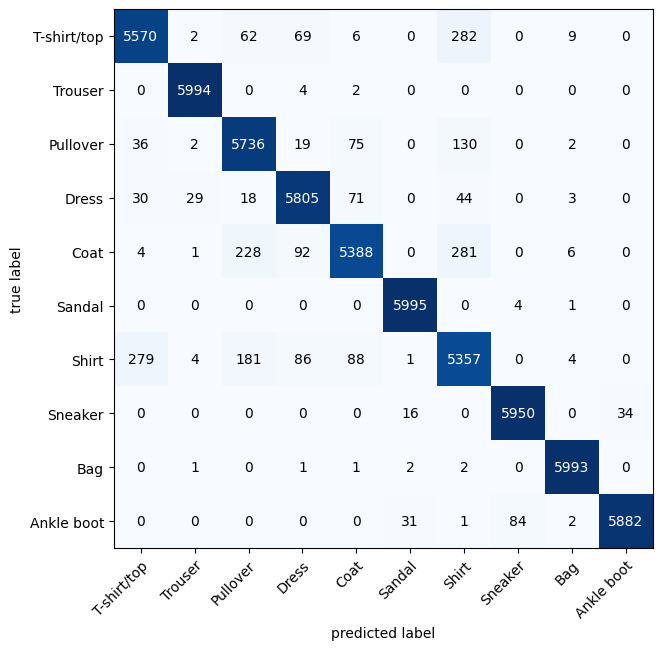

In [71]:
# 8. CNN model
#     - TinyVGG 에서 모델 architecture를 복제함 (https://poloclub.github.io/cnn-explainer/)
#     - 상당히 괜찮게 결과가 나온다

class FashionMNISTMLPClassifier(torch.nn.Module):
    def __init__(self, input_channel_size, input_square_size, output_shape, hidden_units):
        super().__init__()
        self.block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels  = input_channel_size,  # input image의 channel 수
                out_channels = hidden_units, 
                kernel_size  = 3, # how big is the square that's going over the image?
                stride       = 1, # default
                padding      = 1  # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            ),    
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                in_channels  = hidden_units, 
                out_channels = hidden_units,
                kernel_size  = 3,
                stride       = 1,
                padding      = 1
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(
                kernel_size=2,
                stride=2        # kernel size = 2, stride = 2 이므로 output의 면적은 input 면적의 1/4이 된다
            )
        )
        self.block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )

        # block_1 MaxPool2d : 28*28 -> 14*14
            # block_2 MaxPool2d : 14*14 -> 7*7
        classifier_square_size = input_square_size // 4 # block_1, block_2에서 MaxPool2d를 통과했으므로 1/4로 줄어든다

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(
                in_features  = hidden_units * classifier_square_size * classifier_square_size, 
                out_features = output_shape
            )
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
    
# train data의 첫번째 이미지에서 크기를 가져온다
image, label = train_data[0]
input_channel_size = image.shape[0] # image가 grayscale이라고 가정
input_square_size  = image.shape[1] # image가 square라고 가정
    
model_cnn = FashionMNISTMLPClassifier(
    input_channel_size,
    input_square_size,
    output_shape = len(class_names),
    hidden_units = 32
).to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
epochs = 10
t_start = timeit.default_timer()

for e in range(epochs):
    print(f'Epoch: {e+1}/{epochs}')
    train_step(model_cnn, train_dataloader, loss_func, optimizer)
    test_step(test_dataloader, model_cnn, loss_func)

t_end = timeit.default_timer()

print(f'Elapsed time: {t_end - t_start:.2f} seconds')

display_confusion_matrix(train_dataloader, model_cnn, class_names)